In [1]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import wandb

from dawgz import job, after, ensure, schedule
from itertools import chain, islice
from pathlib import Path
from torch import Tensor
Tensor
from tqdm import tqdm
from typing import *
import pandas as pd

from lampe.data import H5Dataset
from zuko.distributions import BoxUniform
from lampe.inference import NPE, NPELoss
from lampe.nn import ResMLP
from zuko.flows import NAF, NSF, MAF, NCSF, SOSPF, UNAF, CNF 
from lampe.plots import nice_rc, corner, coverage_plot, mark_point
from lampe.utils import GDStep

import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from DataProcuring import Data 
from ProcessingSpec import ProcessSpec
from parameter import *
from spectra_simulator import SpectrumMaker
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal
# from spectra_simulator import Simulator, LOWER, UPPER
# from AverageEstimator import avgestimator

# sys.path.insert(0, '/home/mvasist/Highres/sbi/added_scripts/')
from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *


# from ees import Simulator, LOWER, UPPER, LABELS, pt_profile
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
[                  r'$b$',  1, 20.0], # PH3_mol_scale

])

os.environ['SCRATCH'] = os.path.join('/scratch/users/mvasist/')
scratch = os.environ['SCRATCH']
datapath = Path(scratch) / 'highres-sbi/data_nic5'
savepath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise'

processing = ProcessSpec()
d = Data()
sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)


def simulator(theta):
    values = theta[:-4].numpy()
    values_ext = theta[-4:].numpy()
    # print(values, values_ext)
    values_actual = deNormVal(values, param_list)
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    
    values_ext_actual = deNormVal(values_ext, param_list_ext)
    # params_ext = param_set_ext.param_dict(values_ext_actual)
    
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))
    # print(np.shape(x))
    return x.squeeze()


## Loading from a model to plot
CONFIGS = {
    'embedding': ['shallow'],
    'flow': ['MAF'],  #, 'NCSF', 'SOSPF', 'UNAF', 'CNF'], #'NAF', 
    'transforms': [3], #, 7], #3, 
    # 'signal': [16, 32],  # not important- the autoregression network output , 32
    'hidden_features': [512], # hidden layers of the autoregression network , 256, 
    'hidden_features_no' : [5], 
    'activation': [nn.ELU], #, nn.ReLU],
    'optimizer': ['AdamW'],
    'init_lr':  [1e-3], #[5e-4, 1e-5]
    'weight_decay': [1e-4], #[1e-4], #
    'scheduler': ['ReduceLROnPlateau'], #, 'CosineAnnealingLR'],
    'min_lr': [1e-5], # 1e-6
    'patience': [16], #8
    'epochs': [350],
    'stop_criterion': ['early'], #, 'late'],
    'batch_size':  [256],
    'spectral_length' : [6144], #[1536, 3072, 6144]
    'factor' : [0.3], 
    'noise_scaling' : [2], 
    'noise' : ['lognormaldist']
    # 'SOSF_degree' : [2,3,4],
    # 'SOSF_poly' : [2,4,6],
}



/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [2]:
d = Data()

In [3]:
scratch = os.environ.get('SCRATCH', '')
datapath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise' 

runpath = datapath / 'honest-totem-81'
ep = 900
savepath = runpath/ ('plots_' + str(ep))


In [8]:
df_theta = pd.read_csv(savepath/'theta.csv')
theta = df_theta.values
theta = torch.from_numpy(theta)
# theta = theta*(torch.Tensor(UPPER)-torch.Tensor(LOWER)) + torch.Tensor(LOWER)


In [9]:
# x_star =  torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/x_sim_b.npy'))[0]
# theta_star = torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/theta_sim_b.npy'))

In [10]:
# plt.rcParams.update(nice_rc(latex=True))
# plt.figure(figsize=(15,7))
# # plt.errorbar(x[0, 1], x[0,0], yerr= d.err**d.flux_scaling*25, color = 'steelblue', label = 'betsfit')
# plt.plot(d.data_wavelengths_norm, d.flux*d.flux_scaling, color = 'black')
# plt.xlabel('Wavelength (mu)', fontsize = 20)
# plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
# plt.show()

In [11]:
## Sam's retrieval

theta_sam = torch.load('/home/mvasist/Highres/Sam/Model_2/Mine/posterior.pth')

In [13]:
th_df = pd.DataFrame(theta[:20469])

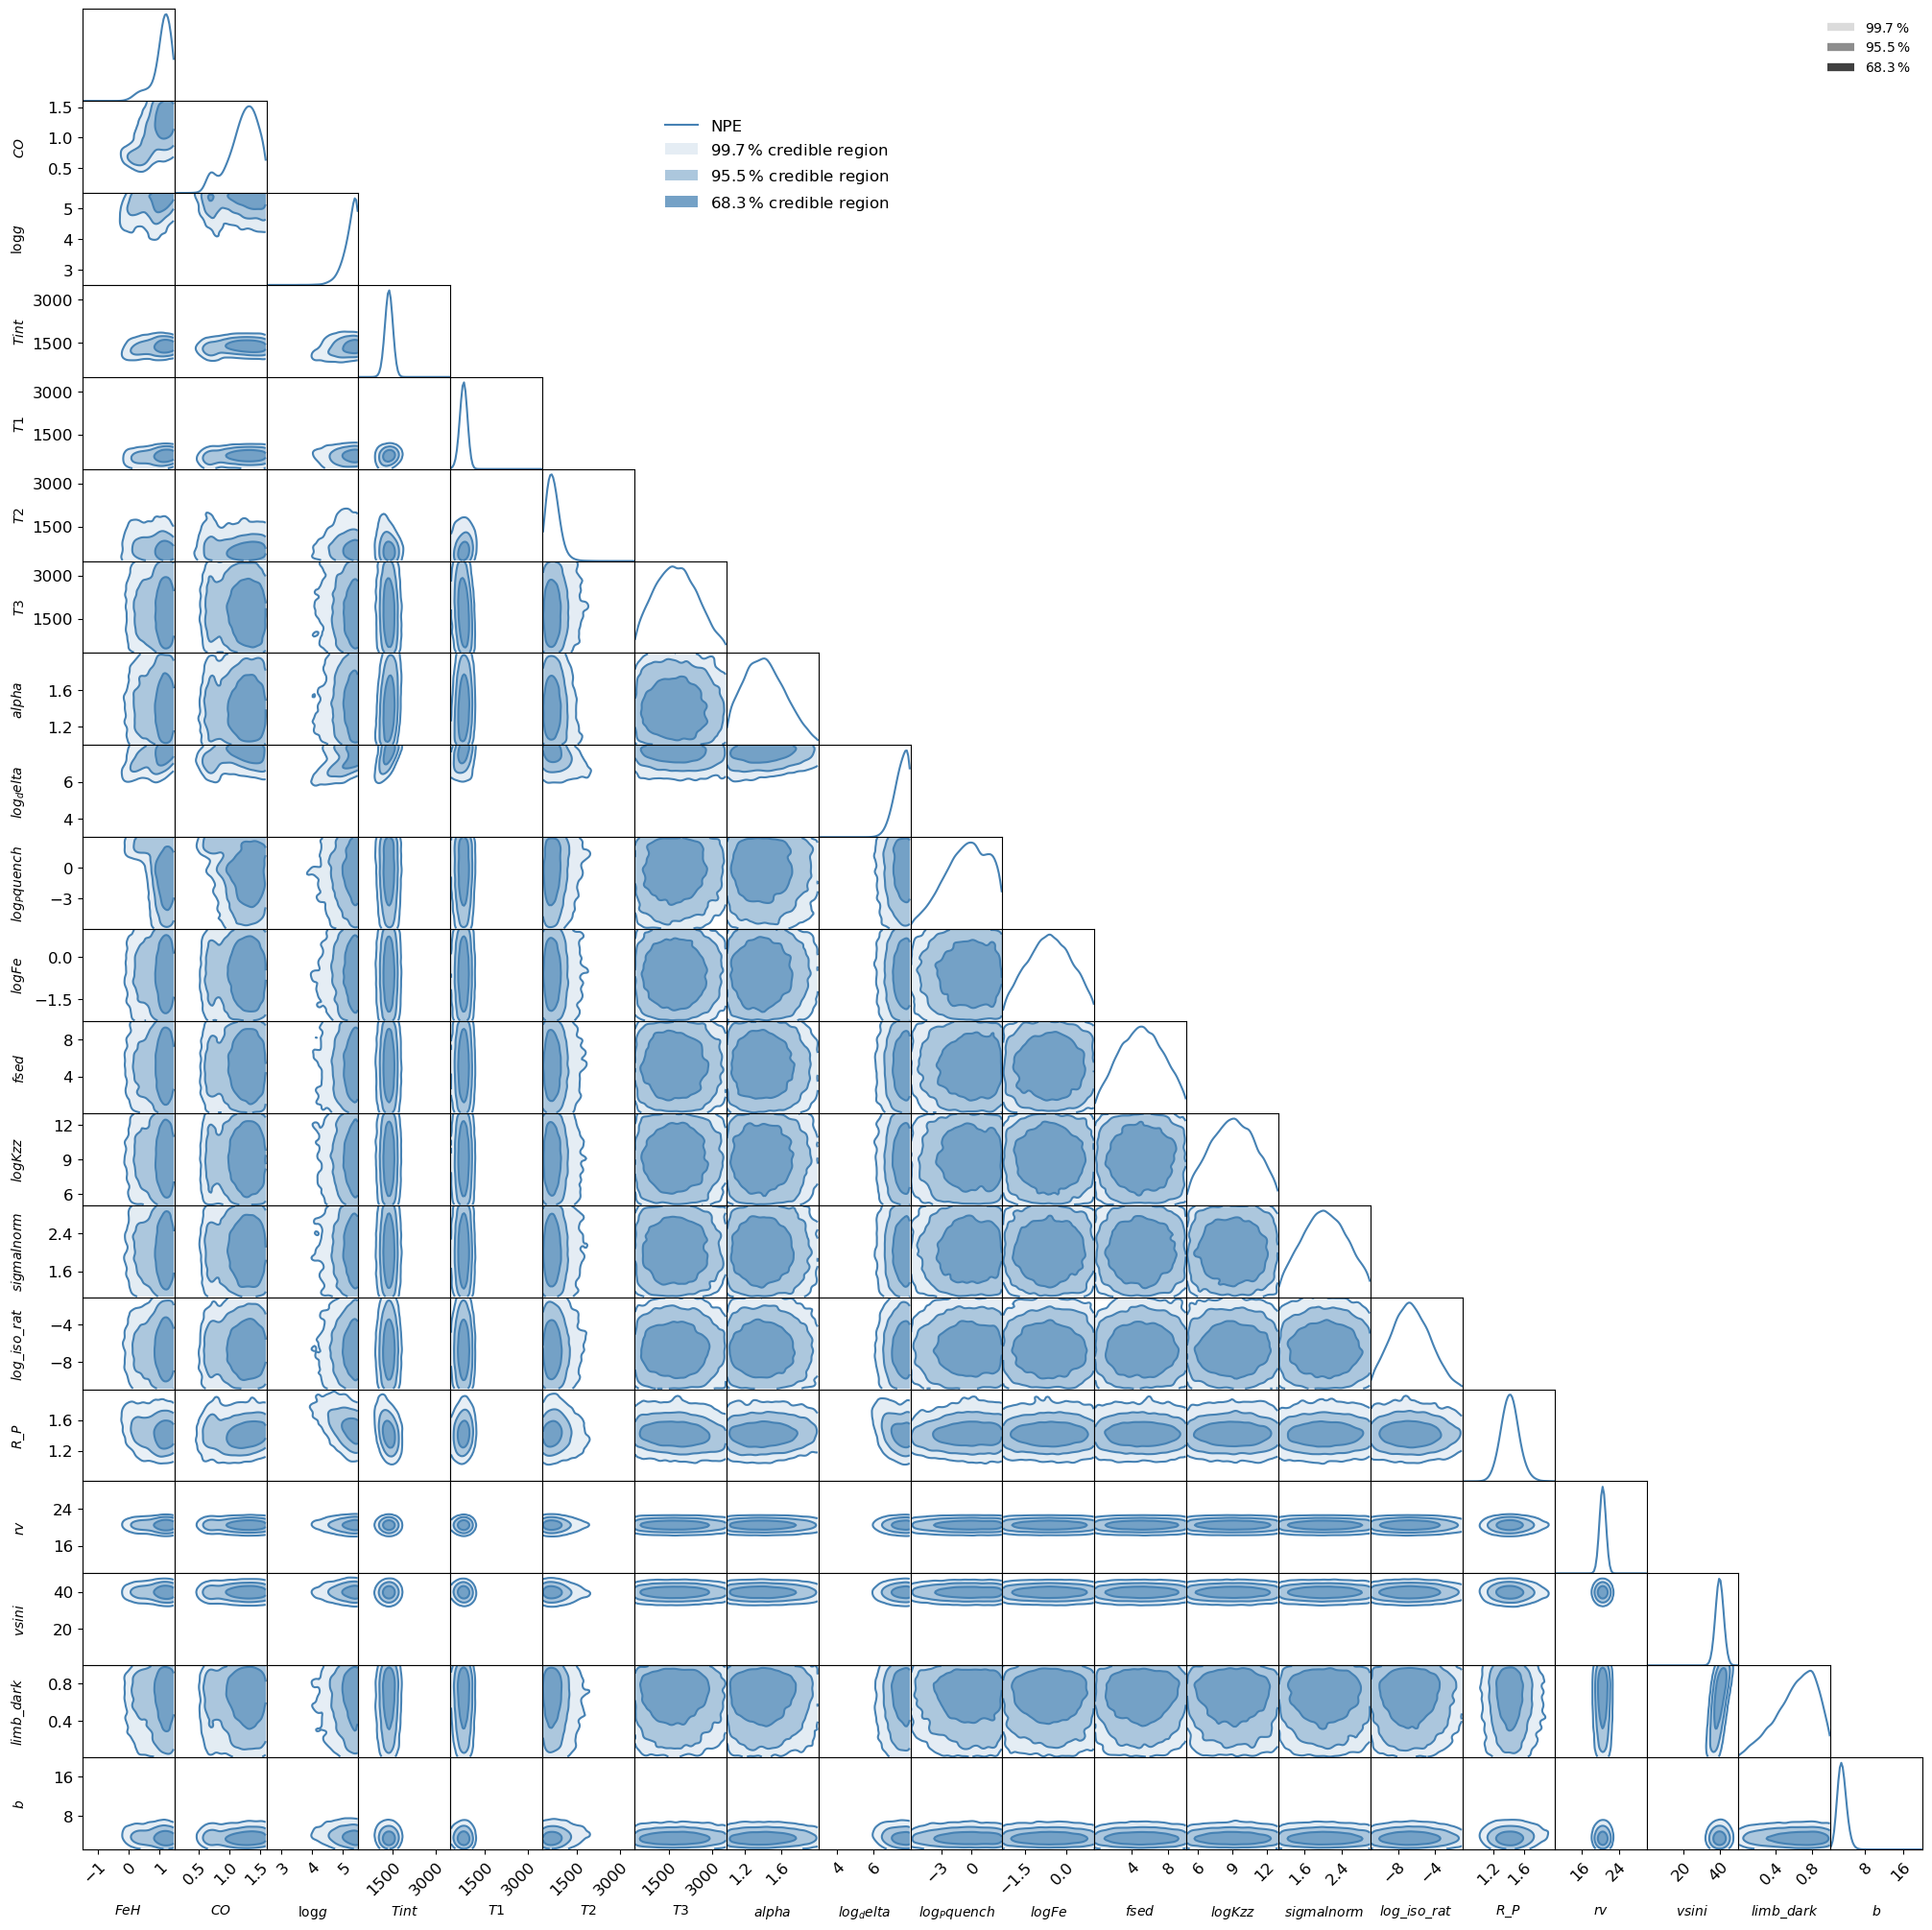

In [14]:
corner_mod([th_df.values], legend=['NPE'], \
                color= ['steelblue'] , figsize=(20,20), \
             domain = (LOWER, UPPER), labels= LABELS) #


In [ ]:
th_df_ = th_df.drop( columns= [7, 8, 10, 11, 12, 13, 14, 18, 19 ], axis=1)

In [ ]:
th_df_

In [ ]:
th_df_sam = pd.DataFrame(theta_sam)
th_df_sam

In [ ]:
# fig = corner_mod([th_df_.values, theta_sam], legend=['NPE', 'MultiNest'], \
#                     color= ['steelblue', 'orange'] , figsize=(12,12), \
#                  domain = (LOWER, UPPER), labels= LABELS) #

In [ ]:
# for i in range(12):
#     plt.hist(th_df_sam.values[:,i])
#     plt.show()

In [ ]:
from corner import corner

In [ ]:
LABELS

In [ ]:
labels = LABELS
print(labels)

In [ ]:
7, 10, 11, 12, 13, 14, 18, 19

In [ ]:
labels = LABELS[:7] + LABELS[9:10] + LABELS[15:18] 

In [ ]:
labels

In [ ]:
np.shape(th_df_), np.shape(th_df_sam)

In [ ]:
figure = corner(th_df_sam.values)
fig = corner(th_df_.values[:2991], fig=figure, color='red', labels = labels )


In [ ]:
fig

In [1]:
# Highres/Sam/obs/DENIS_J0255_ergscm2nm
# Highres/observation/data/
import numpy as np 

wv = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_wave.npy')
fl = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_flux.npy') 
err = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_err.npy')


In [2]:
wv, fl, err

(array([[[2321.53846792, 2321.54642203, 2321.554376  , ...,
          2337.49354591, 2337.50118836, 2337.50883066],
         [2338.64830132, 2338.65591865, 2338.66353581, ...,
          2353.88968122, 2353.89696395, 2353.90424651],
         [2354.97365038, 2354.98090713, 2354.98816372, ...,
          2369.45566989, 2369.46256922, 2369.46946836]]]),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]))

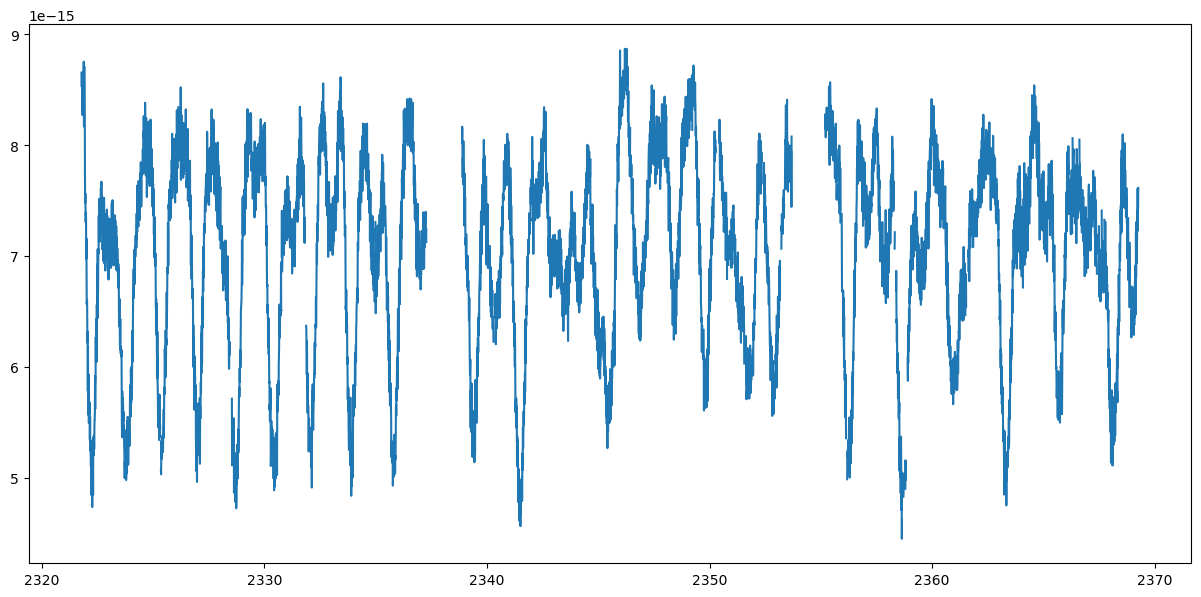

In [9]:
plt.figure(figsize=(15,7))
plt.plot( wv.flatten(), fl.flatten())
plt.show()

In [10]:
d.flux_scaling

2.4969280588665137e-05

In [15]:
## erg/s/cm2/nm == W/m2/um

import astropy.constants as const
import astropy.units as u

def unit_conversion(flux, distance=4.866*u.pc):
    flux_units = flux * u.erg/u.s/u.cm**2/u.nm
    flux_dens_emit = (flux_units * distance**2/const.R_jup**2).to(u.W/u.m**2/u.micron)
    return flux_dens_emit.value

In [16]:
fl_ = unit_conversion( fl.flatten())

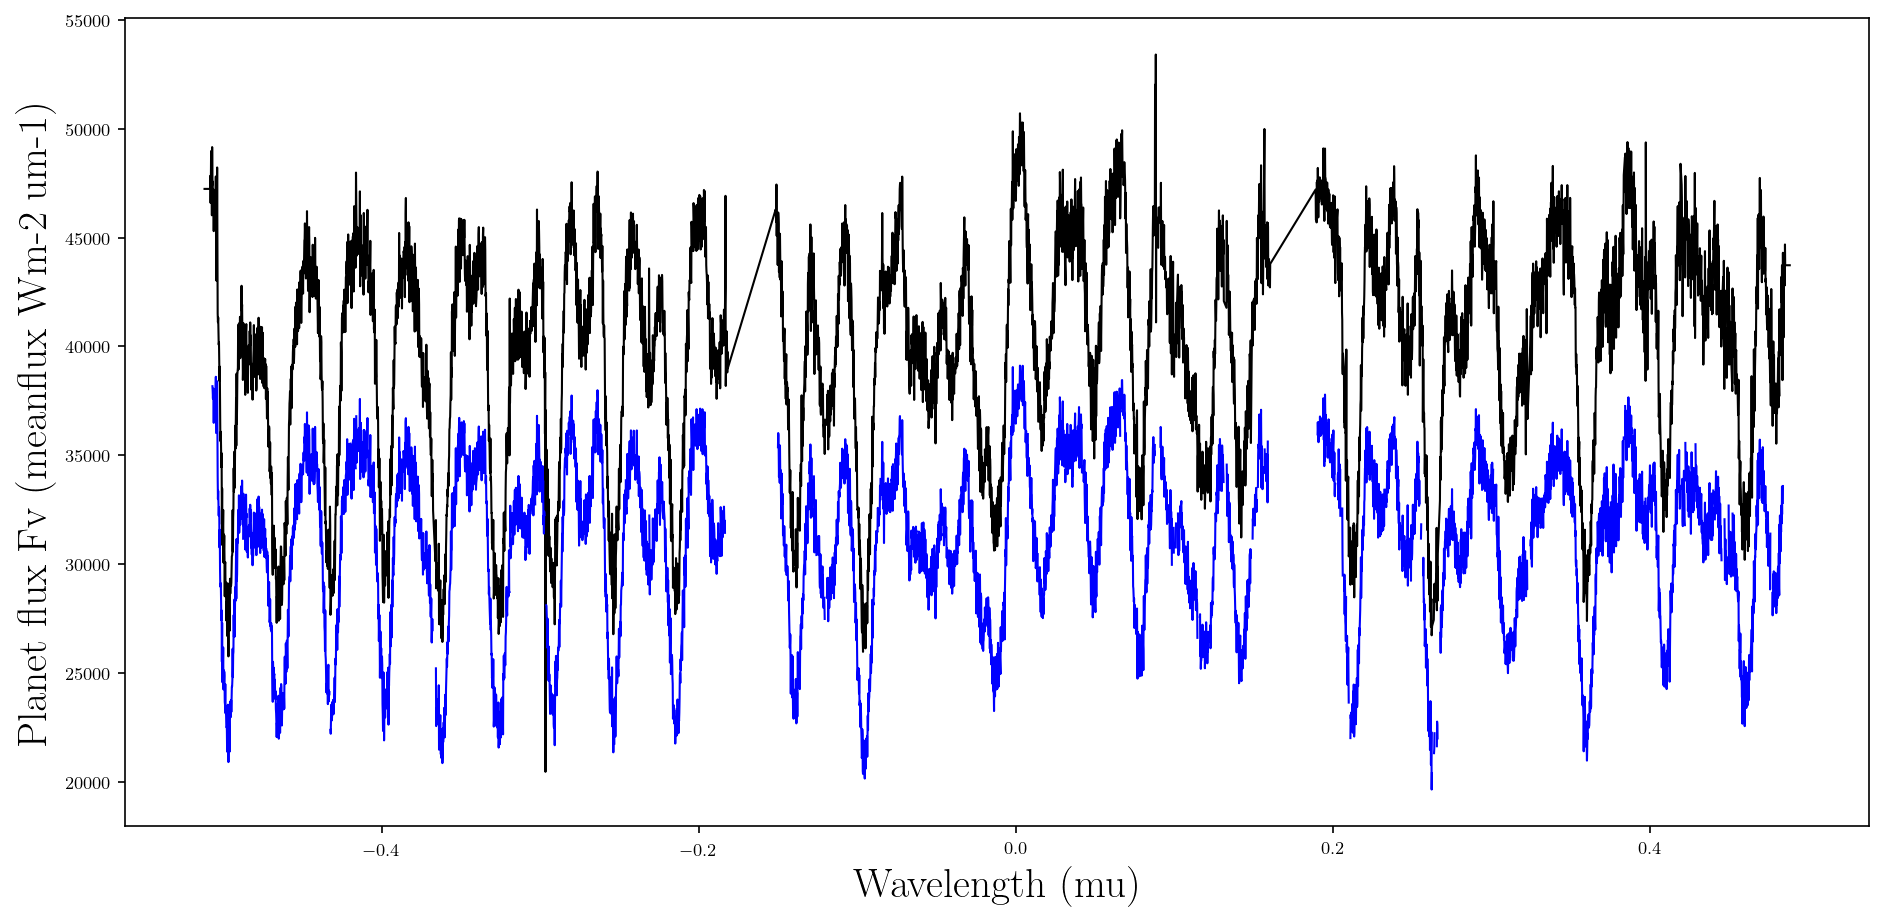

In [19]:
plt.rcParams.update(nice_rc(latex=True))
plt.figure(figsize=(15,7))
# plt.errorbar(x[0, 1], x[0,0], yerr= d.err**d.flux_scaling*25, color = 'steelblue', label = 'betsfit')
plt.plot(d.data_wavelengths_norm, d.flux, color = 'black')
plt.plot(d.data_wavelengths_norm, fl_, color = 'blue')
plt.xlabel('Wavelength (mu)', fontsize = 20)
plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
plt.show()




In [22]:
d.flux, fl_

(array([47241.60883395, 47241.60883395, 47241.60883395, ...,
        43732.7703355 , 43732.7703355 , 43732.7703355 ]),
 array([nan, nan, nan, ..., nan, nan, nan]))